## 1. Setup & Configuration

In [1]:
# Core imports
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.covariance import EllipticEnvelope
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("All imports successful!")

All imports successful!


In [2]:
# ============================================
# CONFIGURATION - MODIFY THESE VALUES
# ============================================

# Path to your features CSV file
INPUT_FILE = "/home/smotaali/BGP_Traffic_Generation/results/rrc05_updates_20251216_extracted.csv"

# Output directory (leave None to save in same directory as input)
OUTPUT_DIR = '/home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN'

# Estimated anomaly rate (0.1 = 10%)
# If you have no idea, start with 0.1
CONTAMINATION_ESTIMATE = 0.10

# Label column name (if you have existing labels)
EXISTING_LABEL_COL = 'label'  # Set to None if no existing labels

# Time column name (for temporal analysis)
TIME_COL = 'window_start'  # Set to None if no time column

# Random seed for reproducibility
RANDOM_STATE = 42

# ============================================
# PLOT SAVING CONFIGURATION
# ============================================
SAVE_PLOTS = True  # Set to True to save all plots
PLOT_FORMAT = 'png'  # 'png', 'pdf', 'svg'
PLOT_DPI = 150  # Resolution (150 for screen, 300 for publication)

# Create output directory for plots
from pathlib import Path
input_path = Path(INPUT_FILE)
output_dir = Path(OUTPUT_DIR) if OUTPUT_DIR else input_path.parent
PLOT_DIR = output_dir / f"{input_path.stem}_plots"

if SAVE_PLOTS:
    PLOT_DIR.mkdir(exist_ok=True)
    print(f"Plots will be saved to: {PLOT_DIR}")

def save_plot(fig, name):
    """Helper function to save plots"""
    if SAVE_PLOTS:
        filepath = PLOT_DIR / f"{name}.{PLOT_FORMAT}"
        fig.savefig(filepath, dpi=PLOT_DPI, bbox_inches='tight')
        print(f"  Saved: {filepath}")

print(f"Configuration set:")
print(f"  Input file: {INPUT_FILE}")
print(f"  Contamination estimate: {CONTAMINATION_ESTIMATE*100:.0f}%")
print(f"  Save plots: {SAVE_PLOTS}")

Plots will be saved to: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots
Configuration set:
  Input file: /home/smotaali/BGP_Traffic_Generation/results/rrc05_updates_20251216_extracted.csv
  Contamination estimate: 10%
  Save plots: True


## 2. Load and Explore Data

In [3]:
# Load the data
df = pd.read_csv(INPUT_FILE)

print(f"Loaded {len(df)} samples")
print(f"Columns: {len(df.columns)}")
print(f"\nColumn names:")
for i, col in enumerate(df.columns):
    print(f"  {i+1}. {col}")

Loaded 86400 samples
Columns: 30

Column names:
  1. announcements
  2. withdrawals
  3. nlri_ann
  4. dups
  5. origin_0
  6. origin_2
  7. origin_changes
  8. as_path_max
  9. unique_as_path_max
  10. edit_distance_avg
  11. edit_distance_max
  12. edit_distance_dict_0
  13. edit_distance_dict_1
  14. edit_distance_dict_2
  15. edit_distance_dict_3
  16. edit_distance_dict_4
  17. edit_distance_dict_5
  18. edit_distance_dict_6
  19. edit_distance_unique_dict_0
  20. edit_distance_unique_dict_1
  21. imp_wd
  22. imp_wd_spath
  23. imp_wd_dpath
  24. number_rare_ases
  25. rare_ases_avg
  26. flaps
  27. nadas
  28. label
  29. window_start
  30. window_end


In [4]:
# Basic statistics
print("Data Overview:")
print("="*60)
df.info()
print("\n")
df.describe()

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86400 entries, 0 to 86399
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   announcements                86400 non-null  int64  
 1   withdrawals                  86400 non-null  int64  
 2   nlri_ann                     86400 non-null  int64  
 3   dups                         86400 non-null  int64  
 4   origin_0                     86400 non-null  int64  
 5   origin_2                     86400 non-null  int64  
 6   origin_changes               86400 non-null  int64  
 7   as_path_max                  86400 non-null  int64  
 8   unique_as_path_max           86400 non-null  int64  
 9   edit_distance_avg            86400 non-null  float64
 10  edit_distance_max            86400 non-null  int64  
 11  edit_distance_dict_0         86400 non-null  int64  
 12  edit_distance_dict_1         86400 non-null  int64  
 13  e

,announcements,withdrawals,nlri_ann,dups,origin_0,origin_2,origin_changes,as_path_max,unique_as_path_max,edit_distance_avg,...,edit_distance_dict_6,edit_distance_unique_dict_0,edit_distance_unique_dict_1,imp_wd,imp_wd_spath,imp_wd_dpath,number_rare_ases,rare_ases_avg,flaps,nadas
count,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,...,86400.00000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000,86400.000000
mean,512.534352,44.471007,512.534352,19.569977,475.260475,35.788229,2.119919,13.325266,9.351088,2.094051,...,2.08169,10.287674,30.075289,36.844109,12.310382,24.533727,74.066991,0.048269,14.710347,17.595579
std,1665.161926,125.384287,1665.161926,52.674938,1463.081820,217.175131,10.776558,3.900687,3.596386,0.552919,...,10.22552,25.173607,65.092826,74.657910,38.184698,45.809084,176.776980,0.030690,50.622457,120.097035
min,5.000000,0.000000,5.000000,0.000000,5.000000,0.000000,0.000000,5.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000620,0.000000,0.000000
25%,95.000000,5.000000,95.000000,4.000000,91.000000,1.000000,0.000000,11.000000,7.000000,1.761905,...,0.00000,3.000000,8.000000,11.000000,2.000000,7.000000,24.000000,0.026136,2.000000,3.000000
50%,157.000000,11.000000,157.000000,9.000000,151.000000,3.000000,1.000000,12.000000,9.000000,2.065934,...,1.00000,5.000000,13.000000,19.000000,5.000000,13.000000,33.000000,0.042373,4.000000,7.000000
75%,350.000000,23.000000,350.000000,17.000000,334.000000,10.000000,2.000000,14.000000,11.000000,2.390244,...,2.00000,9.000000,22.000000,32.000000,9.000000,23.000000,67.000000,0.064484,8.000000,14.000000
max,50918.000000,2712.000000,50918.000000,1609.000000,43420.000000,7550.000000,869.000000,56.000000,36.000000,11.383621,...,1497.00000,711.000000,2124.000000,1415.000000,887.000000,1111.000000,5194.000000,0.533333,892.000000,4410.000000


Existing label distribution (label):
  normal: 86400 (100.0%)


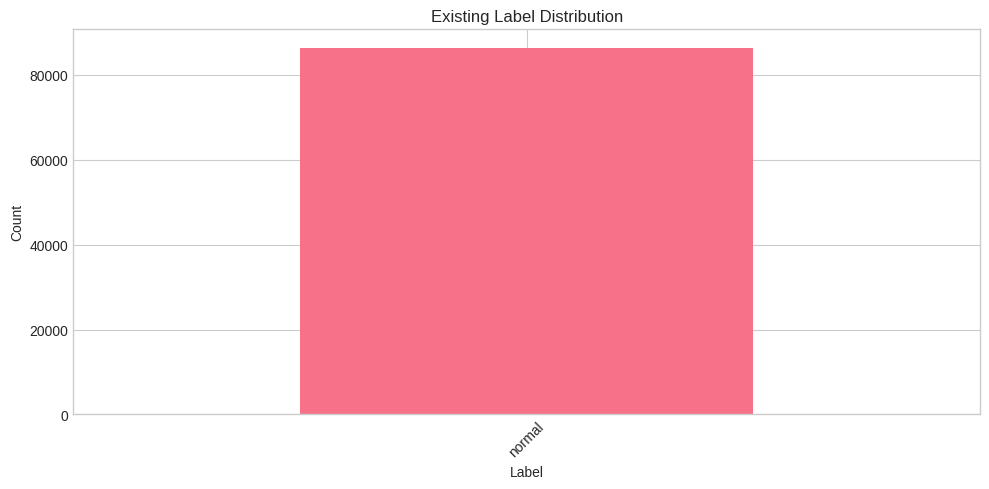

In [5]:
# Check existing labels if present
if EXISTING_LABEL_COL and EXISTING_LABEL_COL in df.columns:
    print(f"Existing label distribution ({EXISTING_LABEL_COL}):")
    print("="*40)
    label_counts = df[EXISTING_LABEL_COL].value_counts()
    for label, count in label_counts.items():
        pct = count / len(df) * 100
        print(f"  {label}: {count} ({pct:.1f}%)")
    
    # Visualize
    plt.figure(figsize=(10, 5))
    label_counts.plot(kind='bar', color=sns.color_palette("husl", len(label_counts)))
    plt.title('Existing Label Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No existing labels found - this is fine!")
    print("We will discover labels from the data.")

## 3. Prepare Features

In [6]:
# Identify feature columns (exclude metadata)
META_COLS = {
    'incident', 'window_start', 'window_end', 'timestamp', 'time',
    'label', 'label_rule', 'label_refined', 'label_discovered',
    'cluster', 'anomaly_score', 'source', 'collector'
}

# Get numeric columns that are not metadata
candidate_cols = [c for c in df.columns if c.lower() not in {m.lower() for m in META_COLS}]
feature_cols = df[candidate_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"Identified {len(feature_cols)} feature columns:")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")

Identified 27 feature columns:
  1. announcements
  2. withdrawals
  3. nlri_ann
  4. dups
  5. origin_0
  6. origin_2
  7. origin_changes
  8. as_path_max
  9. unique_as_path_max
  10. edit_distance_avg
  11. edit_distance_max
  12. edit_distance_dict_0
  13. edit_distance_dict_1
  14. edit_distance_dict_2
  15. edit_distance_dict_3
  16. edit_distance_dict_4
  17. edit_distance_dict_5
  18. edit_distance_dict_6
  19. edit_distance_unique_dict_0
  20. edit_distance_unique_dict_1
  21. imp_wd
  22. imp_wd_spath
  23. imp_wd_dpath
  24. number_rare_ases
  25. rare_ases_avg
  26. flaps
  27. nadas


In [7]:
# Prepare feature matrix
X = df[feature_cols].values

# Handle missing values
valid_mask = ~np.isnan(X).any(axis=1)
X_valid = X[valid_mask]

print(f"Valid samples: {len(X_valid)} / {len(X)}")
print(f"Excluded due to NaN: {(~valid_mask).sum()}")

# Scale features (RobustScaler is robust to outliers)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_valid)

print(f"\nFeature matrix shape: {X_scaled.shape}")

Valid samples: 86400 / 86400
Excluded due to NaN: 0

Feature matrix shape: (86400, 27)


## 4. Hyperparameter Tuning & Explanation

Before running anomaly detection, let's understand and tune the key parameters.

### Parameter Reference Table

| Parameter | Default | Range | How to Choose |
|-----------|---------|-------|---------------|
| `n_estimators` (IF) | 200 | 100-500 | More = stable but slower. 200 is usually enough |
| `n_neighbors` (LOF) | 20 | 5-50 | √n_samples or use tuning below |
| `IQR multiplier` | 1.5 | 1.5-3.0 | 1.5=standard, 3.0=very conservative |
| `PCA components` | 10 | 5-20 | Preserve ~95% variance |
| `DBSCAN eps` | auto | varies | Use k-distance graph |
| `min_samples` (DBSCAN) | 5 | 3-10 | Higher = fewer clusters |

In [8]:
# ============================================
# HYPERPARAMETER CONFIGURATION
# ============================================
# These are the key parameters you can tune

# 1. Isolation Forest
N_ESTIMATORS = 200  # Number of trees (100-500, more = stable but slower)

# 2. Local Outlier Factor  
# Rule of thumb: sqrt(n_samples) or between 10-50
N_NEIGHBORS_LOF = max(10, min(50, int(np.sqrt(len(X_valid)))))

# 3. Statistical Outliers
IQR_MULTIPLIER = 1.5  # Standard=1.5, Conservative=2.0, Very Conservative=3.0
Z_SCORE_THRESHOLD = 3  # Standard=3, Conservative=2.5

# 4. PCA Components (for DBSCAN)
# Will be set based on variance explained

# 5. DBSCAN
MIN_SAMPLES_DBSCAN = 5  # Minimum points to form a cluster

print("Hyperparameters configured:")
print(f"  Isolation Forest n_estimators: {N_ESTIMATORS}")
print(f"  LOF n_neighbors: {N_NEIGHBORS_LOF} (based on sqrt({len(X_valid)}))")
print(f"  IQR multiplier: {IQR_MULTIPLIER}")
print(f"  Z-score threshold: {Z_SCORE_THRESHOLD}")
print(f"  DBSCAN min_samples: {MIN_SAMPLES_DBSCAN}")

Hyperparameters configured:
  Isolation Forest n_estimators: 200
  LOF n_neighbors: 50 (based on sqrt(86400))
  IQR multiplier: 1.5
  Z-score threshold: 3
  DBSCAN min_samples: 5


Tuning LOF n_neighbors...


  n_neighbors=5: 10.0% anomalies
  n_neighbors=10: 10.0% anomalies
  n_neighbors=15: 10.0% anomalies
  n_neighbors=20: 10.0% anomalies
  n_neighbors=30: 10.0% anomalies
  n_neighbors=40: 10.0% anomalies
  n_neighbors=50: 10.0% anomalies


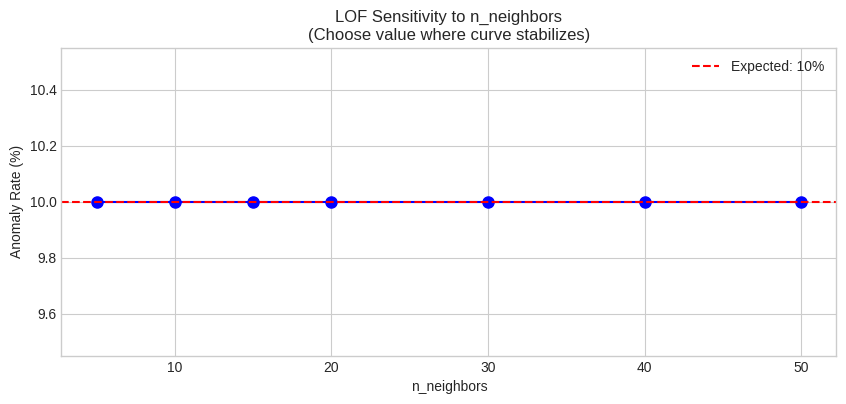


Recommended n_neighbors: 5


In [9]:
# Tune LOF n_neighbors using stability analysis
print("Tuning LOF n_neighbors...")

neighbor_range = [5, 10, 15, 20, 30, 40, 50]
neighbor_range = [n for n in neighbor_range if n < len(X_valid) // 2]  # Must be less than n_samples/2

lof_stability = []
for n in neighbor_range:
    lof_temp = LocalOutlierFactor(n_neighbors=n, contamination=CONTAMINATION_ESTIMATE)
    preds = lof_temp.fit_predict(X_scaled)
    anomaly_rate = (preds == -1).mean()
    lof_stability.append((n, anomaly_rate))
    print(f"  n_neighbors={n}: {anomaly_rate*100:.1f}% anomalies")

# Plot
plt.figure(figsize=(10, 4))
ns, rates = zip(*lof_stability)
plt.plot(ns, [r*100 for r in rates], 'bo-', markersize=8)
plt.axhline(y=CONTAMINATION_ESTIMATE*100, color='red', linestyle='--', 
            label=f'Expected: {CONTAMINATION_ESTIMATE*100:.0f}%')
plt.xlabel('n_neighbors')
plt.ylabel('Anomaly Rate (%)')
plt.title('LOF Sensitivity to n_neighbors\n(Choose value where curve stabilizes)')
plt.legend()
plt.grid(True)
plt.show()

# Find most stable value (closest to expected contamination)
best_n = min(lof_stability, key=lambda x: abs(x[1] - CONTAMINATION_ESTIMATE))[0]
print(f"\nRecommended n_neighbors: {best_n}")

Analyzing PCA variance...
  Components for 90% variance: 4
  Components for 95% variance: 7


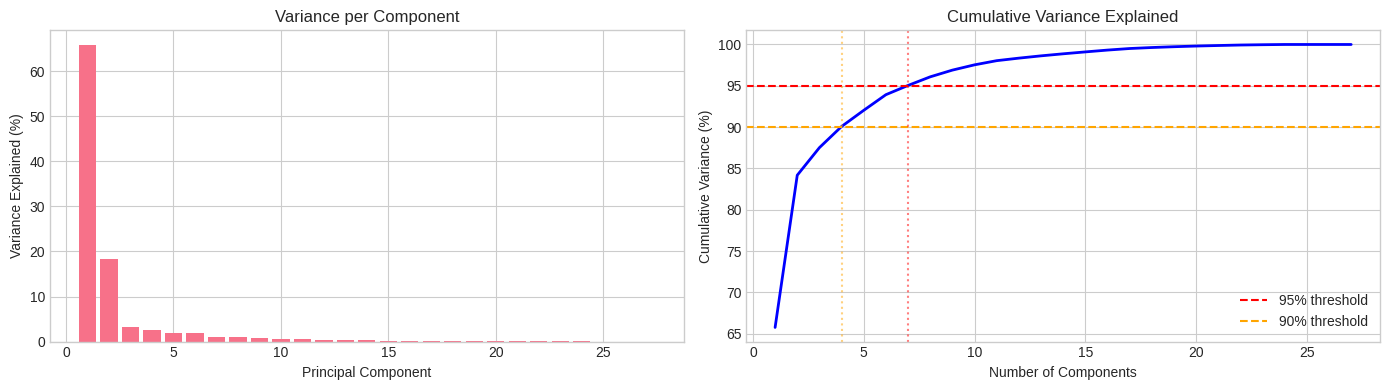


Using 7 PCA components (95% variance)


In [10]:
# Determine optimal PCA components (preserve 95% variance)
print("Analyzing PCA variance...")

pca_full = PCA()
pca_full.fit(X_scaled)

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

print(f"  Components for 90% variance: {n_components_90}")
print(f"  Components for 95% variance: {n_components_95}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Individual variance
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_*100)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained (%)')
axes[0].set_title('Variance per Component')

# Cumulative variance
axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance*100, 'b-', linewidth=2)
axes[1].axhline(y=95, color='red', linestyle='--', label='95% threshold')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90% threshold')
axes[1].axvline(x=n_components_95, color='red', linestyle=':', alpha=0.5)
axes[1].axvline(x=n_components_90, color='orange', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance (%)')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Set optimal PCA components
N_PCA_COMPONENTS = n_components_95
print(f"\nUsing {N_PCA_COMPONENTS} PCA components (95% variance)")

## 5. Anomaly Detection Methods (with tuned parameters)

Now we run the 5 methods using the parameters we tuned above.

In [11]:
# Method 1: Isolation Forest (using tuned parameters)
print("[1/5] Running Isolation Forest...")

iso_forest = IsolationForest(
    n_estimators=N_ESTIMATORS,  # Using tuned parameter
    contamination=CONTAMINATION_ESTIMATE,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

iso_predictions = iso_forest.fit_predict(X_scaled)
iso_scores = iso_forest.decision_function(X_scaled)

iso_anomalies = (iso_predictions == -1)
print(f"  Parameters: n_estimators={N_ESTIMATORS}")
print(f"  Found {iso_anomalies.sum()} anomalies ({iso_anomalies.mean()*100:.1f}%)")

[1/5] Running Isolation Forest...
  Parameters: n_estimators=200
  Found 8640 anomalies (10.0%)


In [12]:
# Method 2: Local Outlier Factor (using tuned parameters)
print("[2/5] Running Local Outlier Factor...")

lof = LocalOutlierFactor(
    n_neighbors=N_NEIGHBORS_LOF,  # Using tuned parameter
    contamination=CONTAMINATION_ESTIMATE,
    novelty=False
)

lof_predictions = lof.fit_predict(X_scaled)
lof_scores = lof.negative_outlier_factor_

lof_anomalies = (lof_predictions == -1)
print(f"  Parameters: n_neighbors={N_NEIGHBORS_LOF}")
print(f"  Found {lof_anomalies.sum()} anomalies ({lof_anomalies.mean()*100:.1f}%)")

[2/5] Running Local Outlier Factor...


  Parameters: n_neighbors=50
  Found 8640 anomalies (10.0%)


In [13]:
# Method 3: Statistical Analysis (using tuned parameters)
print("[3/5] Running Statistical Analysis...")

def statistical_outlier_scores(X, z_threshold=3, iqr_mult=1.5):
    """Calculate outlier scores using Z-score and IQR."""
    n_samples, n_features = X.shape
    outlier_scores = np.zeros(n_samples)
    
    for i in range(n_features):
        col = X[:, i]
        
        # Z-score method (tunable threshold)
        z_scores = np.abs(stats.zscore(col, nan_policy='omit'))
        z_outliers = z_scores > z_threshold
        
        # IQR method (tunable multiplier)
        Q1, Q3 = np.percentile(col, [25, 75])
        IQR = Q3 - Q1
        iqr_outliers = (col < Q1 - iqr_mult * IQR) | (col > Q3 + iqr_mult * IQR)
        
        outlier_scores += z_outliers.astype(float) + iqr_outliers.astype(float)
    
    return outlier_scores / (2 * n_features)

# Use tuned parameters
stat_scores = statistical_outlier_scores(X_valid, 
                                          z_threshold=Z_SCORE_THRESHOLD,
                                          iqr_mult=IQR_MULTIPLIER)
stat_threshold = np.percentile(stat_scores, 100 * (1 - CONTAMINATION_ESTIMATE))
stat_anomalies = stat_scores > stat_threshold

print(f"  Parameters: Z-score threshold={Z_SCORE_THRESHOLD}, IQR multiplier={IQR_MULTIPLIER}")
print(f"  Found {stat_anomalies.sum()} anomalies ({stat_anomalies.mean()*100:.1f}%)")

[3/5] Running Statistical Analysis...
  Parameters: Z-score threshold=3, IQR multiplier=1.5
  Found 8076 anomalies (9.3%)


In [14]:
# Method 4: Elliptic Envelope (Robust Covariance)
print("[4/5] Running Elliptic Envelope...")

try:
    elliptic = EllipticEnvelope(
        contamination=CONTAMINATION_ESTIMATE,
        random_state=RANDOM_STATE
    )
    elliptic_predictions = elliptic.fit_predict(X_scaled)
    elliptic_scores = elliptic.decision_function(X_scaled)
    elliptic_anomalies = (elliptic_predictions == -1)
    print(f"  Found {elliptic_anomalies.sum()} anomalies ({elliptic_anomalies.mean()*100:.1f}%)")
    elliptic_success = True
except Exception as e:
    print(f"  Skipped due to error: {e}")
    elliptic_anomalies = np.zeros(len(X_valid), dtype=bool)
    elliptic_scores = np.zeros(len(X_valid))
    elliptic_success = False

[4/5] Running Elliptic Envelope...
  Found 8640 anomalies (10.0%)


[5/5] Running HDBSCAN Clustering...
  PCA variance explained: 95.0%
  Running HDBSCAN on 86400 samples...
  Parameters: min_cluster_size=50, min_samples=5
  Found 10 clusters, 81639 noise points

  Using outlier_scores for anomaly detection:
  Outlier score threshold (top 10%): 0.682
  Anomalies detected: 8640 (10.0%)
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/06_hdbscan_results.png


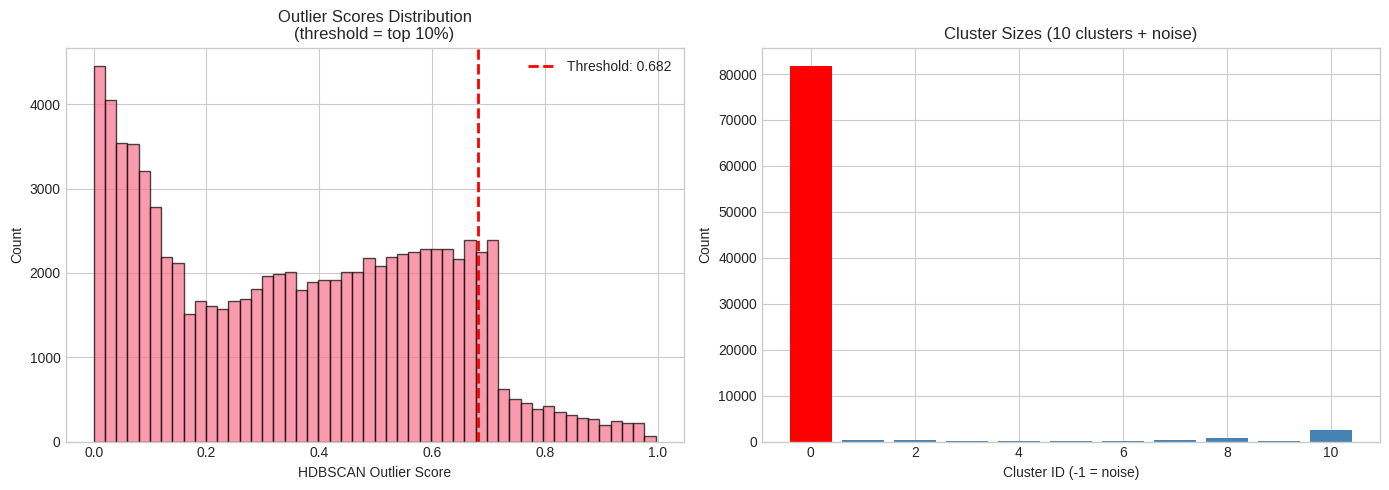

In [15]:
# Method 5: HDBSCAN (using outlier_scores, NOT cluster noise)
print("[5/5] Running HDBSCAN Clustering...")

# Install hdbscan if not available
try:
    import hdbscan
except ImportError:
    print("Installing hdbscan...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'hdbscan', '-q'])
    import hdbscan

import gc

# Use PCA with tuned components
pca = PCA(n_components=N_PCA_COMPONENTS)
X_pca = pca.fit_transform(X_scaled)
print(f"  PCA variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# HDBSCAN parameters
MIN_CLUSTER_SIZE = 50   
MIN_SAMPLES = 5        

print(f"  Running HDBSCAN on {len(X_pca)} samples...")
print(f"  Parameters: min_cluster_size={MIN_CLUSTER_SIZE}, min_samples={MIN_SAMPLES}")

# HDBSCAN 
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=MIN_SAMPLES,
    cluster_selection_method='leaf',
    prediction_data=False,
    core_dist_n_jobs=-1
)

hdbscan_labels = clusterer.fit_predict(X_pca)

# Get outlier scores
outlier_scores = clusterer.outlier_scores_

# Clean up
gc.collect()

# Calculate n_clusters (THIS WAS MISSING!)
n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
noise_count = (hdbscan_labels == -1).sum()
print(f"  Found {n_clusters} clusters, {noise_count} noise points")

# Use outlier_scores with threshold (NOT noise labels)
outlier_threshold = np.percentile(outlier_scores, 100 * (1 - CONTAMINATION_ESTIMATE))
hdbscan_anomalies = outlier_scores > outlier_threshold

anomaly_rate = hdbscan_anomalies.mean() * 100
print(f"\n  Using outlier_scores for anomaly detection:")
print(f"  Outlier score threshold (top {CONTAMINATION_ESTIMATE*100:.0f}%): {outlier_threshold:.3f}")
print(f"  Anomalies detected: {hdbscan_anomalies.sum()} ({anomaly_rate:.1f}%)")

# Store for later use
dbscan_anomalies = hdbscan_anomalies
dbscan_labels = hdbscan_labels

# Show outlier score distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Outlier score histogram
axes[0].hist(outlier_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=outlier_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Threshold: {outlier_threshold:.3f}')
axes[0].set_xlabel('HDBSCAN Outlier Score')
axes[0].set_ylabel('Count')
axes[0].set_title(f'Outlier Scores Distribution\n(threshold = top {CONTAMINATION_ESTIMATE*100:.0f}%)')
axes[0].legend()

# Cluster sizes
cluster_counts = pd.Series(hdbscan_labels).value_counts().sort_index()
colors_bar = ['red' if idx == -1 else 'steelblue' for idx in cluster_counts.index]
axes[1].bar(range(len(cluster_counts)), cluster_counts.values, color=colors_bar)
axes[1].set_xlabel('Cluster ID (-1 = noise)')
axes[1].set_ylabel('Count')
axes[1].set_title(f'Cluster Sizes ({n_clusters} clusters + noise)')

plt.tight_layout()
save_plot(fig, '06_hdbscan_results')
plt.show()

## 5. Compute Consensus

In [16]:
# Count votes from all methods
n_methods = 5 if elliptic_success else 4

anomaly_votes = (
    iso_anomalies.astype(int) +
    lof_anomalies.astype(int) +
    stat_anomalies.astype(int) +
    elliptic_anomalies.astype(int) +
    dbscan_anomalies.astype(int)
)

consensus_score = anomaly_votes / n_methods

# Assign discovered labels based on consensus
discovered_labels = np.where(
    consensus_score >= 0.8, 'high_confidence_anomaly',
    np.where(
        consensus_score >= 0.5, 'likely_anomaly',
        np.where(
            consensus_score >= 0.2, 'uncertain',
            'likely_normal'
        )
    )
)

print("Consensus Results:")
print("="*50)
for label in ['likely_normal', 'uncertain', 'likely_anomaly', 'high_confidence_anomaly']:
    count = (discovered_labels == label).sum()
    pct = count / len(discovered_labels) * 100
    emoji = "🟢" if 'normal' in label else "🔴" if 'anomaly' in label else "🟡"
    print(f"  {emoji} {label}: {count} ({pct:.1f}%)")

Consensus Results:
  🟢 likely_normal: 65819 (76.2%)
  🟡 uncertain: 14249 (16.5%)
  🔴 likely_anomaly: 1767 (2.0%)
  🔴 high_confidence_anomaly: 4565 (5.3%)


  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/01_consensus_distribution.png


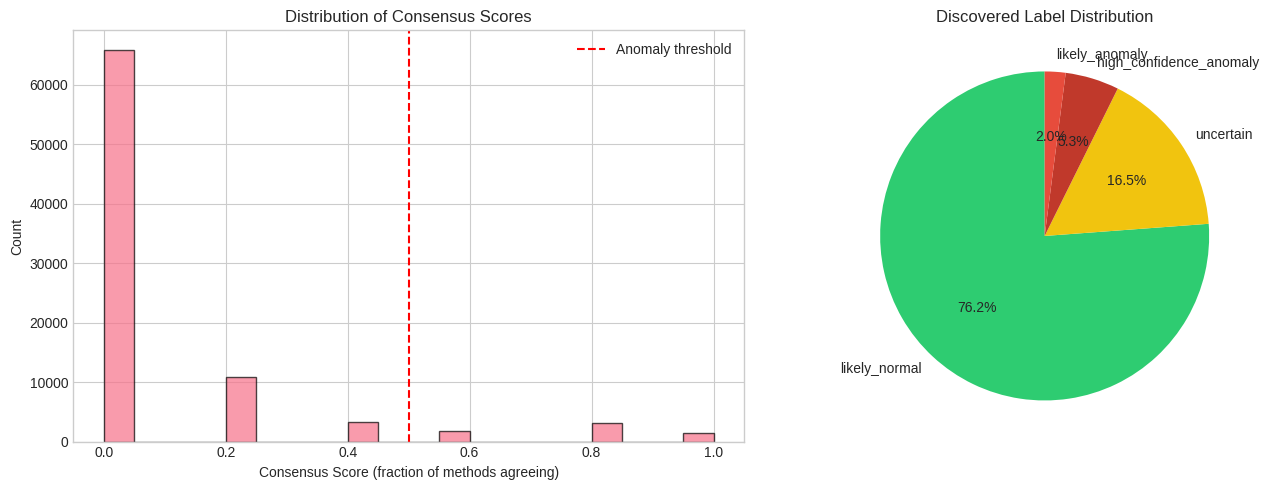

In [17]:
# Visualize consensus distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of consensus scores
axes[0].hist(consensus_score, bins=20, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Consensus Score (fraction of methods agreeing)')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Consensus Scores')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Anomaly threshold')
axes[0].legend()

# Pie chart of discovered labels
label_counts = pd.Series(discovered_labels).value_counts()
colors = {'likely_normal': '#2ecc71', 'uncertain': '#f1c40f', 
          'likely_anomaly': '#e74c3c', 'high_confidence_anomaly': '#c0392b'}
pie_colors = [colors[l] for l in label_counts.index]
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            colors=pie_colors, startangle=90)
axes[1].set_title('Discovered Label Distribution')

plt.tight_layout()
save_plot(fig, '01_consensus_distribution')
plt.show()

## 6. Method Agreement Analysis

  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/02_method_agreement_heatmap.png


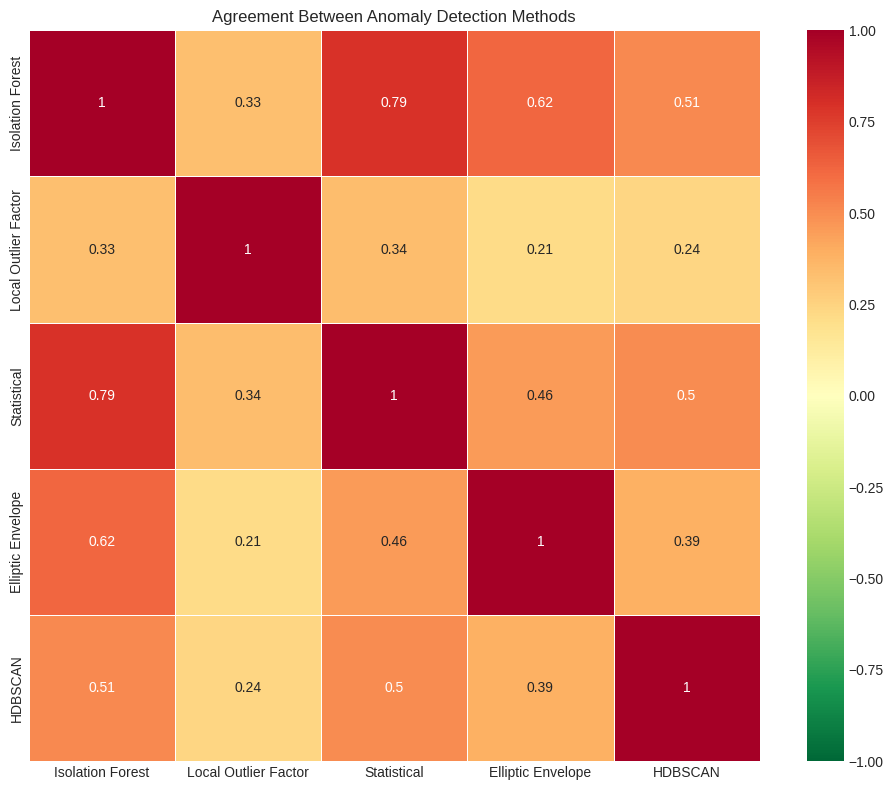


Per-method anomaly rates:
  Isolation Forest: 10.0%
  Local Outlier Factor: 10.0%
  Statistical: 9.3%
  Elliptic Envelope: 10.0%
  HDBSCAN: 10.0%


In [18]:
# Create agreement matrix
methods_df = pd.DataFrame({
    'Isolation Forest': iso_anomalies,
    'Local Outlier Factor': lof_anomalies,
    'Statistical': stat_anomalies,
    'Elliptic Envelope': elliptic_anomalies,
    'HDBSCAN': dbscan_anomalies
})

# Correlation between methods
fig, ax = plt.subplots(figsize=(10, 8))
correlation = methods_df.corr()
sns.heatmap(correlation, annot=True, cmap='RdYlGn_r', center=0,
            vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax)
plt.title('Agreement Between Anomaly Detection Methods')
plt.tight_layout()
save_plot(fig, '02_method_agreement_heatmap')
plt.show()

print("\nPer-method anomaly rates:")
for col in methods_df.columns:
    rate = methods_df[col].mean() * 100
    print(f"  {col}: {rate:.1f}%")

## 7. K-Means Clustering Analysis

Finding optimal number of clusters...
  k=2: silhouette score = 0.9643
  k=3: silhouette score = 0.8555
  k=4: silhouette score = 0.7292
  k=5: silhouette score = 0.7100
  k=6: silhouette score = 0.7145
  k=7: silhouette score = 0.7074
  k=8: silhouette score = 0.7081
  k=9: silhouette score = 0.6494
  k=10: silhouette score = 0.6433

Optimal number of clusters: 2
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/03_silhouette_scores.png


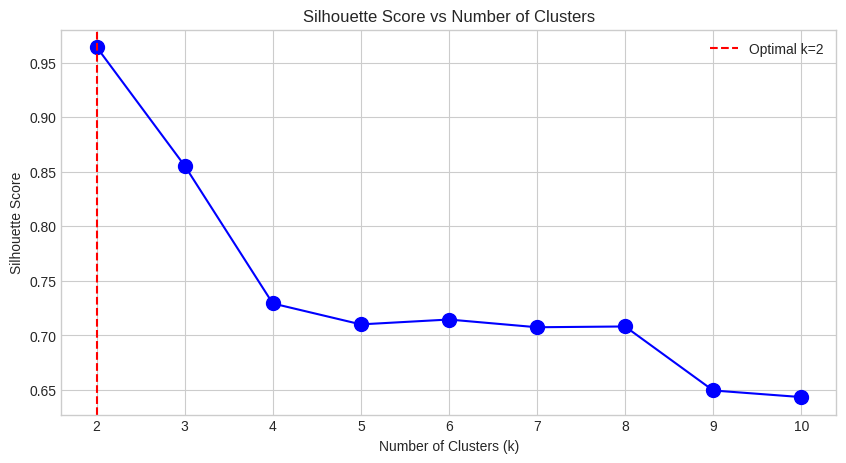

In [19]:
# Find optimal number of clusters using silhouette score
print("Finding optimal number of clusters...")

max_clusters = min(10, len(X_scaled) - 1)
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append((k, score))
    print(f"  k={k}: silhouette score = {score:.4f}")

optimal_k = max(silhouette_scores, key=lambda x: x[1])[0]
print(f"\nOptimal number of clusters: {optimal_k}")

# Plot silhouette scores
fig, ax = plt.subplots(figsize=(10, 5))
ks, scores = zip(*silhouette_scores)
ax.plot(ks, scores, 'bo-', markersize=10)
ax.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k={optimal_k}')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette Score vs Number of Clusters')
ax.legend()
ax.grid(True)
save_plot(fig, '03_silhouette_scores')
plt.show()

In [20]:
# Perform final clustering with optimal k
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print(f"Cluster distribution:")
for i in range(optimal_k):
    count = (cluster_labels == i).sum()
    pct = count / len(cluster_labels) * 100
    print(f"  Cluster {i}: {count} samples ({pct:.1f}%)")

Cluster distribution:
  Cluster 0: 86200 samples (99.8%)
  Cluster 1: 200 samples (0.2%)


  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/04_pca_clusters_anomalies.png


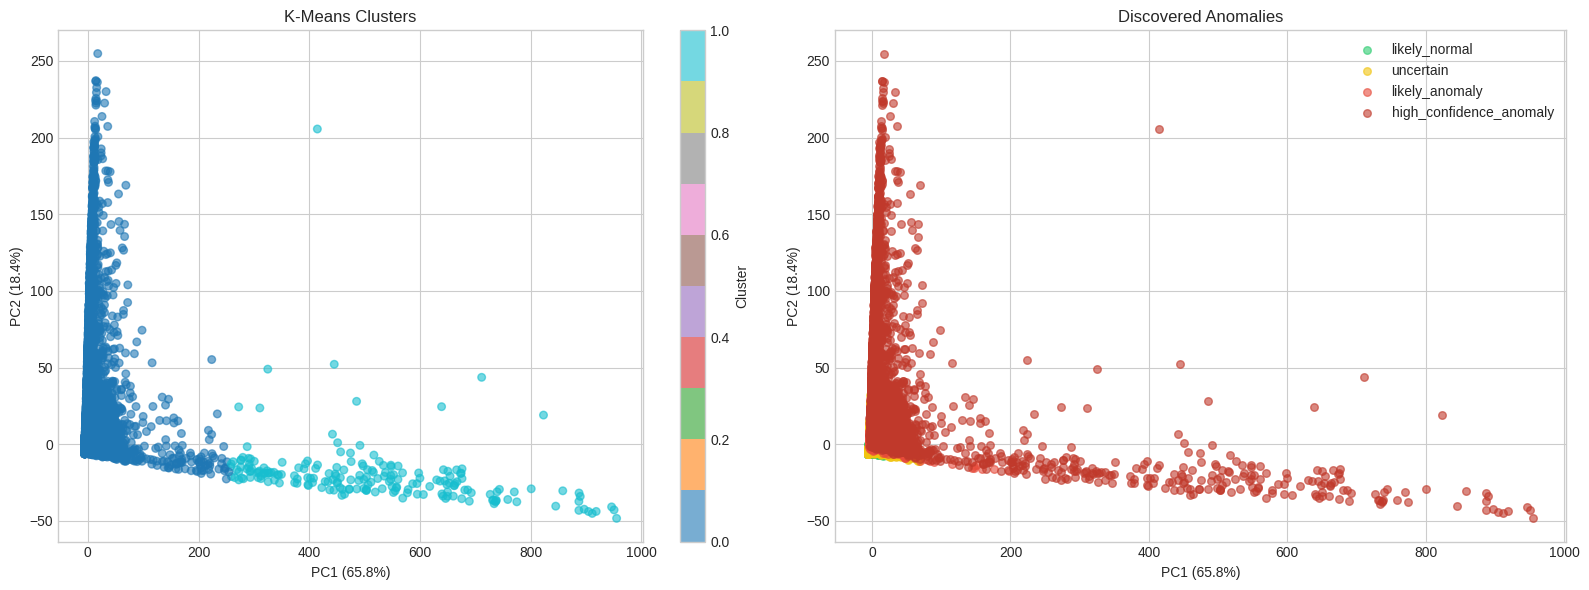

In [21]:
# Visualize clusters using PCA
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: K-Means clusters
scatter1 = axes[0].scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, 
                           cmap='tab10', alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('K-Means Clusters')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Plot 2: Discovered anomalies
colors = {'likely_normal': '#2ecc71', 'uncertain': '#f1c40f', 
          'likely_anomaly': '#e74c3c', 'high_confidence_anomaly': '#c0392b'}
for label in ['likely_normal', 'uncertain', 'likely_anomaly', 'high_confidence_anomaly']:
    mask = discovered_labels == label
    axes[1].scatter(X_2d[mask, 0], X_2d[mask, 1], c=colors[label], 
                    label=label, alpha=0.6, s=30)
axes[1].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].set_title('Discovered Anomalies')
axes[1].legend()

plt.tight_layout()
save_plot(fig, '04_pca_clusters_anomalies')
plt.show()

## 8. Feature Analysis: What Makes Anomalies Different?

In [22]:
# Compare features between normal and anomalous samples
normal_mask = discovered_labels == 'likely_normal'
anomaly_mask = np.isin(discovered_labels, ['high_confidence_anomaly', 'likely_anomaly'])

feature_analysis = []

for i, col in enumerate(feature_cols):
    normal_vals = X_valid[normal_mask, i]
    anomaly_vals = X_valid[anomaly_mask, i]
    
    if len(normal_vals) > 0 and len(anomaly_vals) > 0:
        normal_mean = np.mean(normal_vals)
        anomaly_mean = np.mean(anomaly_vals)
        
        # Cohen's d effect size
        pooled_std = np.sqrt((np.std(normal_vals)**2 + np.std(anomaly_vals)**2) / 2)
        if pooled_std > 0:
            effect_size = abs(anomaly_mean - normal_mean) / pooled_std
        else:
            effect_size = 0
        
        feature_analysis.append({
            'feature': col,
            'normal_mean': normal_mean,
            'anomaly_mean': anomaly_mean,
            'difference': anomaly_mean - normal_mean,
            'effect_size': effect_size,
            'direction': 'higher' if anomaly_mean > normal_mean else 'lower'
        })

# Sort by effect size
feature_analysis = sorted(feature_analysis, key=lambda x: x['effect_size'], reverse=True)

print("Top 10 Most Discriminative Features:")
print("="*70)
print(f"{'Feature':<30} {'Effect Size':>12} {'Direction':>10} {'Normal':>10} {'Anomaly':>10}")
print("-"*70)
for item in feature_analysis[:10]:
    print(f"{item['feature']:<30} {item['effect_size']:>12.3f} {item['direction']:>10} "
          f"{item['normal_mean']:>10.2f} {item['anomaly_mean']:>10.2f}")

Top 10 Most Discriminative Features:
Feature                         Effect Size  Direction     Normal    Anomaly
----------------------------------------------------------------------
rare_ases_avg                         1.673      lower       0.05       0.02
edit_distance_unique_dict_1           1.297     higher      16.48     169.70
imp_wd                                1.222     higher      21.01     196.77
imp_wd_dpath                          1.170     higher      14.99     115.00
edit_distance_dict_1                  1.087     higher      25.90     355.82
flaps                                 1.010     higher       5.76     112.27
edit_distance_unique_dict_0           1.001     higher       5.77      58.46
withdrawals                           0.988     higher      19.36     262.78
imp_wd_spath                          0.912     higher       6.02      81.77
edit_distance_dict_0                  0.891     higher       8.66      92.04


  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/05_feature_distributions.png


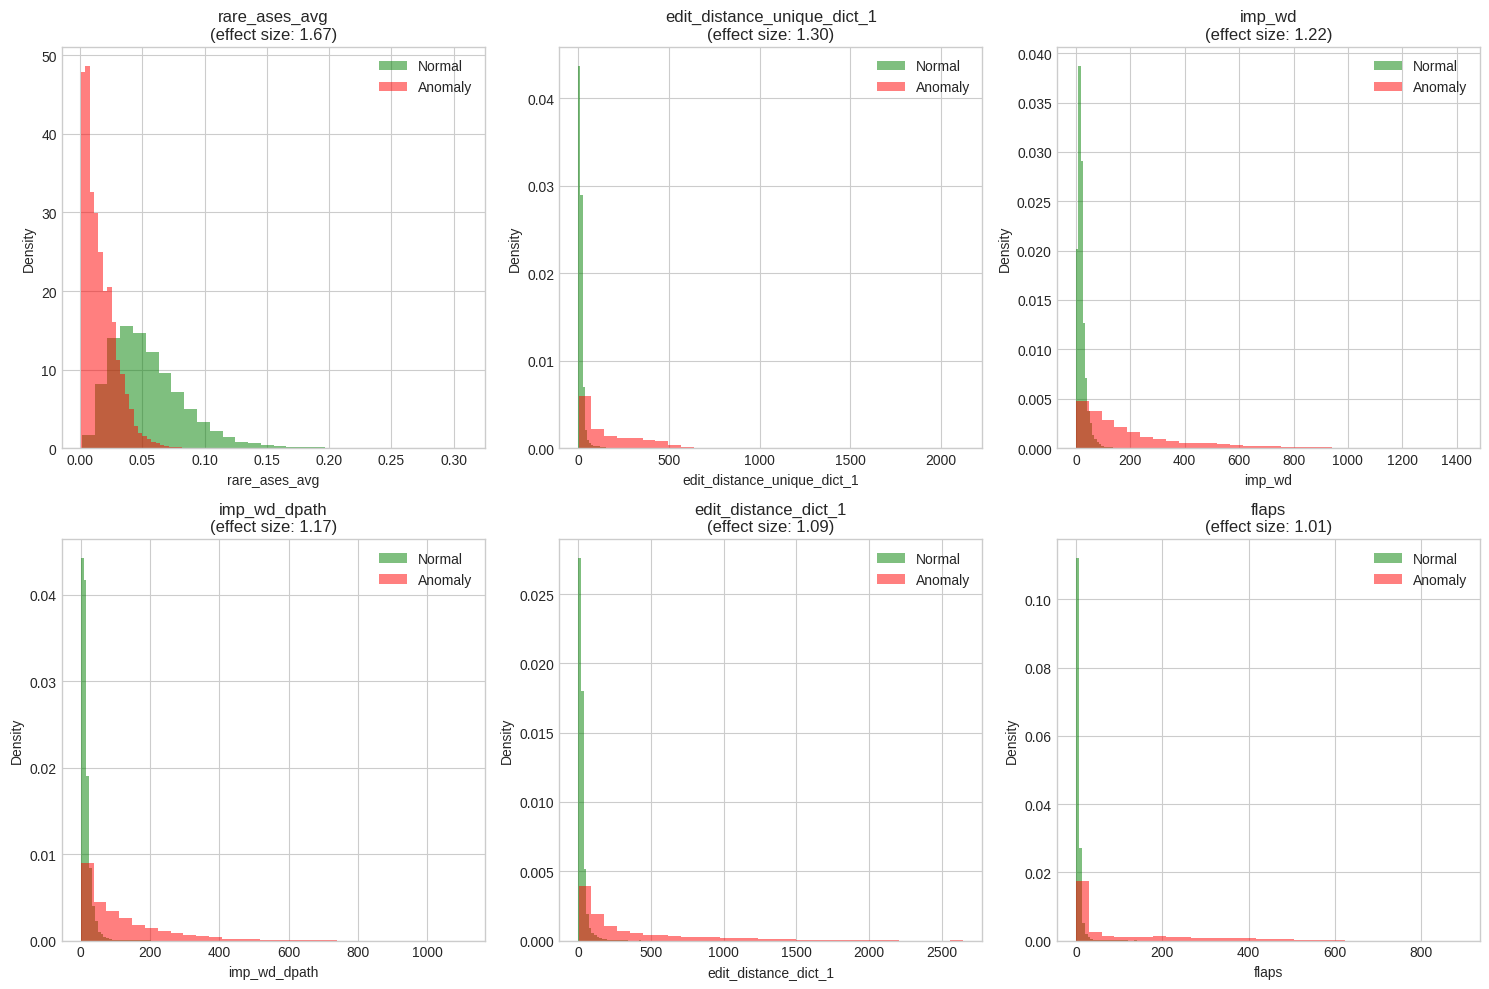

In [23]:
# Visualize top features
top_features = [f['feature'] for f in feature_analysis[:6]]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, feat in enumerate(top_features):
    feat_idx = feature_cols.index(feat)
    
    normal_vals = X_valid[normal_mask, feat_idx]
    anomaly_vals = X_valid[anomaly_mask, feat_idx]
    
    axes[i].hist(normal_vals, bins=30, alpha=0.5, label='Normal', color='green', density=True)
    axes[i].hist(anomaly_vals, bins=30, alpha=0.5, label='Anomaly', color='red', density=True)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Density')
    axes[i].set_title(f'{feat}\n(effect size: {feature_analysis[i]["effect_size"]:.2f})')
    axes[i].legend()

plt.tight_layout()
save_plot(fig, '05_feature_distributions')
plt.show()

## 9. Temporal Analysis (if time column exists)

  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/07_temporal_analysis.png


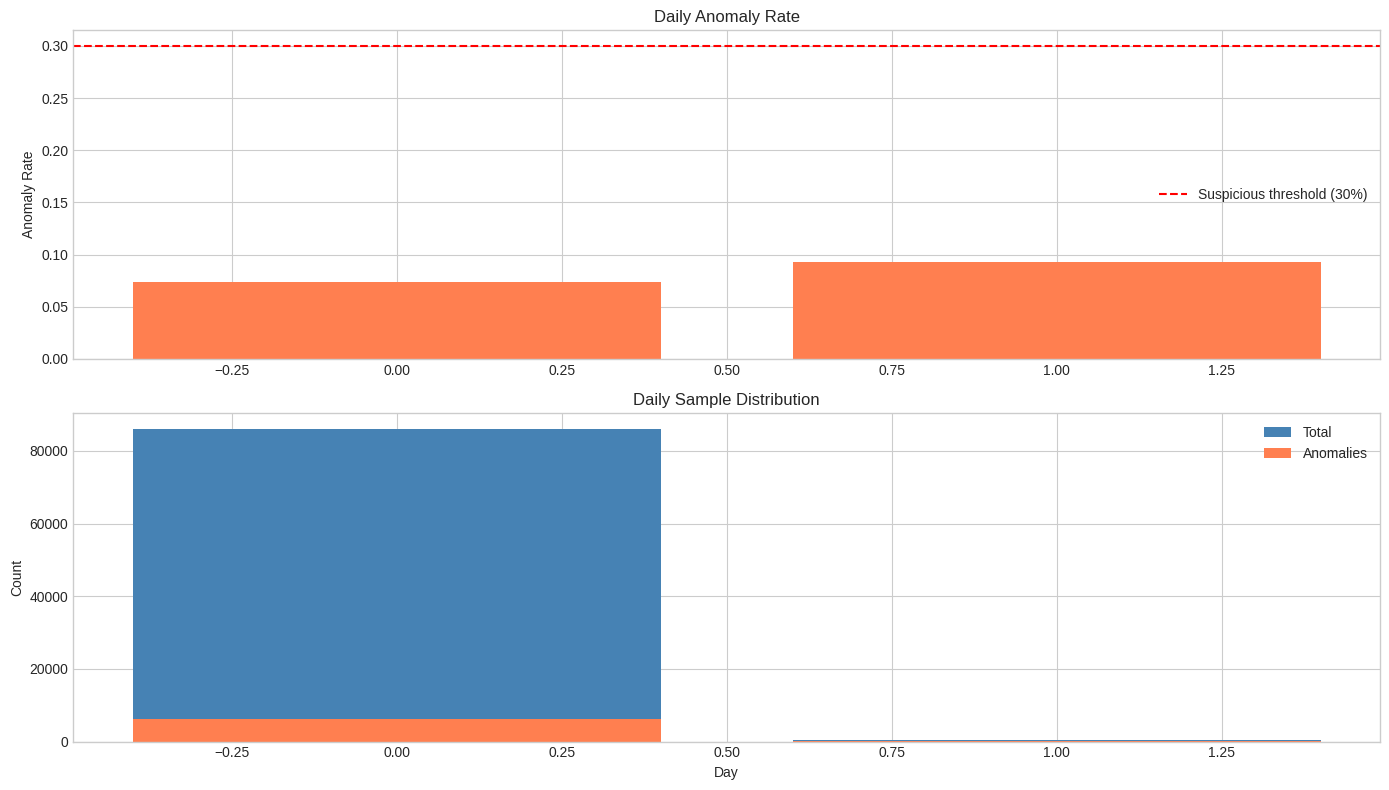


✅ No suspicious time periods found.


In [24]:
if TIME_COL and TIME_COL in df.columns:
    # Create results dataframe for valid samples only
    results_df = df.loc[valid_mask].copy()
    results_df['discovered_label'] = discovered_labels
    results_df['consensus_score'] = consensus_score
    
    # Parse timestamps
    results_df[TIME_COL] = pd.to_datetime(results_df[TIME_COL], errors='coerce')
    results_df = results_df.dropna(subset=[TIME_COL])
    
    if len(results_df) > 0:
        # Group by day
        results_df['date'] = results_df[TIME_COL].dt.date
        
        daily_stats = results_df.groupby('date').agg({
            'consensus_score': ['count', 'mean'],
            'discovered_label': lambda x: x.isin(['high_confidence_anomaly', 'likely_anomaly']).sum()
        }).reset_index()
        daily_stats.columns = ['date', 'total', 'avg_score', 'anomalies']
        daily_stats['anomaly_rate'] = daily_stats['anomalies'] / daily_stats['total']
        
        # Plot temporal distribution
        fig, axes = plt.subplots(2, 1, figsize=(14, 8))
        
        # Plot 1: Daily anomaly rate
        axes[0].bar(range(len(daily_stats)), daily_stats['anomaly_rate'], color='coral')
        axes[0].set_ylabel('Anomaly Rate')
        axes[0].set_title('Daily Anomaly Rate')
        axes[0].axhline(y=0.3, color='red', linestyle='--', label='Suspicious threshold (30%)')
        axes[0].legend()
        
        # Plot 2: Daily sample count
        axes[1].bar(range(len(daily_stats)), daily_stats['total'], color='steelblue', label='Total')
        axes[1].bar(range(len(daily_stats)), daily_stats['anomalies'], color='coral', label='Anomalies')
        axes[1].set_xlabel('Day')
        axes[1].set_ylabel('Count')
        axes[1].set_title('Daily Sample Distribution')
        axes[1].legend()
        
        plt.tight_layout()
        save_plot(fig, '07_temporal_analysis')
        plt.show()
        
        # Find suspicious periods
        suspicious = daily_stats[daily_stats['anomaly_rate'] > 0.3]
        if len(suspicious) > 0:
            print("\n⚠️ SUSPICIOUS PERIODS (>30% anomaly rate):")
            for _, row in suspicious.iterrows():
                print(f"   {row['date']}: {row['anomalies']}/{row['total']} anomalies ({row['anomaly_rate']*100:.1f}%)")
        else:
            print("\n✅ No suspicious time periods found.")
else:
    print("No time column available for temporal analysis.")

## 10. Compare with Existing Labels (if available)

Comparison: Existing Labels vs Discovered Labels

Normalized by existing label (row-wise):
discovered  high_confidence_anomaly  likely_anomaly  likely_normal  uncertain
existing                                                                     
normal                        0.053            0.02          0.762      0.165
All                           0.053            0.02          0.762      0.165
  Saved: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_plots/08_label_comparison.png


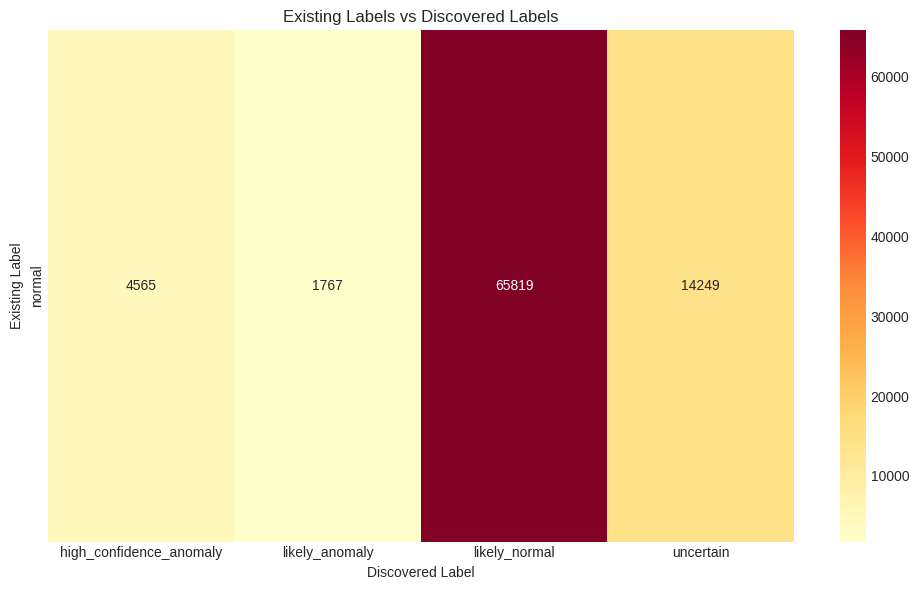


📋 RECOMMENDATIONS:
   ℹ️ 'normal': 76.2% normal, 7.3% anomalous


In [25]:
if EXISTING_LABEL_COL and EXISTING_LABEL_COL in df.columns:
    # Get existing labels for valid samples
    existing_labels = df.loc[valid_mask, EXISTING_LABEL_COL].values
    
    print("Comparison: Existing Labels vs Discovered Labels")
    print("="*70)
    
    comparison_df = pd.DataFrame({
        'existing': existing_labels,
        'discovered': discovered_labels
    })
    
    # Cross-tabulation
    cross_tab = pd.crosstab(comparison_df['existing'], comparison_df['discovered'], 
                            margins=True, normalize='index')
    
    print("\nNormalized by existing label (row-wise):")
    print(cross_tab.round(3))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    cross_tab_counts = pd.crosstab(comparison_df['existing'], comparison_df['discovered'])
    sns.heatmap(cross_tab_counts, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
    plt.title('Existing Labels vs Discovered Labels')
    plt.xlabel('Discovered Label')
    plt.ylabel('Existing Label')
    plt.tight_layout()
    save_plot(fig, '08_label_comparison')
    plt.show()
    
    # Recommendations
    print("\n📋 RECOMMENDATIONS:")
    for existing_label in df[EXISTING_LABEL_COL].unique():
        mask = existing_labels == existing_label
        discovered_dist = pd.Series(discovered_labels[mask]).value_counts(normalize=True)
        
        anomaly_rate = discovered_dist.get('high_confidence_anomaly', 0) + discovered_dist.get('likely_anomaly', 0)
        normal_rate = discovered_dist.get('likely_normal', 0)
        
        if 'normal' in str(existing_label).lower() and anomaly_rate > 0.2:
            print(f"   ⚠️ '{existing_label}': {anomaly_rate*100:.1f}% look anomalous - review these samples!")
        elif 'attack' in str(existing_label).lower() or 'hijack' in str(existing_label).lower():
            if normal_rate > 0.3:
                print(f"   ⚠️ '{existing_label}': {normal_rate*100:.1f}% look normal - possible mislabeling!")
            else:
                print(f"   ✅ '{existing_label}': Looks correctly labeled ({anomaly_rate*100:.1f}% detected as anomalous)")
        else:
            print(f"   ℹ️ '{existing_label}': {normal_rate*100:.1f}% normal, {anomaly_rate*100:.1f}% anomalous")
else:
    print("No existing labels to compare with.")

## 11. Save Results

In [26]:
# Create final results dataframe
results_df = df.copy()

# Add results for valid samples
results_df['iso_forest_score'] = np.nan
results_df['lof_score'] = np.nan
results_df['statistical_score'] = np.nan
results_df['elliptic_score'] = np.nan
results_df['cluster'] = -1
results_df['anomaly_votes'] = np.nan
results_df['consensus_score'] = np.nan
results_df['discovered_label'] = 'invalid'

results_df.loc[valid_mask, 'iso_forest_score'] = iso_scores
results_df.loc[valid_mask, 'lof_score'] = lof_scores
results_df.loc[valid_mask, 'statistical_score'] = stat_scores
results_df.loc[valid_mask, 'elliptic_score'] = elliptic_scores
results_df.loc[valid_mask, 'cluster'] = cluster_labels
results_df.loc[valid_mask, 'anomaly_votes'] = anomaly_votes
results_df.loc[valid_mask, 'consensus_score'] = consensus_score
results_df.loc[valid_mask, 'discovered_label'] = discovered_labels

# Save to file
input_path = Path(INPUT_FILE)
output_dir = Path(OUTPUT_DIR) if OUTPUT_DIR else input_path.parent
output_path = output_dir / f"{input_path.stem}_discovered.csv"

results_df.to_csv(output_path, index=False)
print(f"✅ Results saved to: {output_path}")

# Save anomalies separately
anomalies_df = results_df[results_df['discovered_label'].isin(['high_confidence_anomaly', 'likely_anomaly'])]
if len(anomalies_df) > 0:
    anomalies_path = output_dir / f"{input_path.stem}_anomalies.csv"
    anomalies_df.to_csv(anomalies_path, index=False)
    print(f"✅ Anomalies saved to: {anomalies_path} ({len(anomalies_df)} samples)")

✅ Results saved to: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_discovered.csv
✅ Anomalies saved to: /home/smotaali/BGP_Traffic_Generation/results/final_label_results_HDBSCAN/rrc05_updates_20251216_extracted_anomalies.csv (6332 samples)
